---
DEEP REINFORCEMENT LEARNING EXPLAINED - 19
# **Policy-Gradient Methods**
### REINFORCE Algorithm
---


Import packages

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt


OpenAI Gym's Cartpole Environment

In [2]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('threshold: ', env.spec.reward_threshold)


observation space: Box(4,)
action space: Discrete(2)
threshold:  195.0



Model

In [3]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
     )

print (model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


The REINFORCE training loop

In [4]:
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

MAX_DUR = 500
MAX_EPISODES = 500
gamma = 0.99
score = [] 

for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    for t in range(MAX_DUR):
        act_prob = model(torch.from_numpy(curr_state).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) 
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    score.append(len(transitions))
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 

    batch_qvals =[]
    for i in range(len(transitions)):
        new_qval=0
        power=0
        for j in range(i,len(transitions)):
             new_qval=new_qval+((gamma**power)*reward_batch[j]).numpy()
             power+=1
        batch_qvals.append(new_qval)
    disc_returns_batch=torch.FloatTensor(batch_qvals)
    disc_returns_batch /= disc_returns_batch.max()

    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 

    pred_batch = model(state_batch) 
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() 
    
    loss = -torch.sum(disc_returns_batch * torch.log(prob_batch)) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if episode % 50 == 0 and episode>0:
            print('Episode {}\tAverage Score: {:.2f}'.format(episode, np.mean(score[-50:-1])))

Episode 50	Average Score: 55.12
Episode 100	Average Score: 69.16
Episode 150	Average Score: 89.10
Episode 200	Average Score: 149.55
Episode 250	Average Score: 137.88
Episode 300	Average Score: 144.49
Episode 350	Average Score: 166.78
Episode 400	Average Score: 162.98
Episode 450	Average Score: 171.63


Plot the Scores

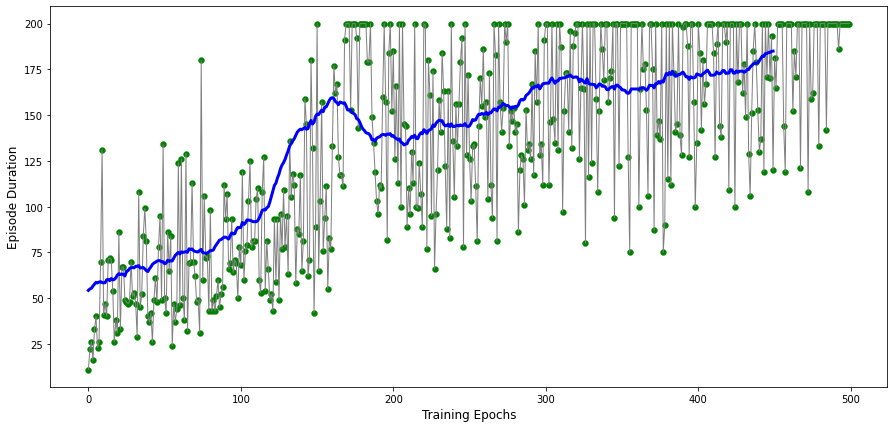

In [5]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Episode Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)

Render Cartpole Environment

In [8]:
# Configuration the image rendering in colab

# Taken from 
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils &> /dev/null

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* &> /dev/null

!pip install gym[box2d]==0.17.* &> /dev/null

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update  &> /dev/null 
!sudo apt-get install xvfb --fix-missing &> /dev/null

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

from IPython import display

:1005


Reward: 200.0


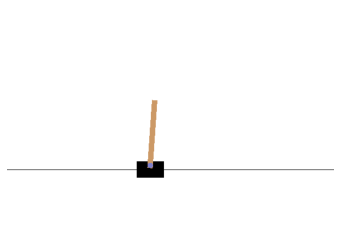

In [7]:
def watch_agent():
  env = gym.make('CartPole-v0')
  state = env.reset()
  rewards = []
  img = plt.imshow(env.render(mode='rgb_array'))
  for t in range(2000):
    pred = model(torch.from_numpy(state).float())
    action = np.random.choice(np.array([0,1]), p=pred.data.numpy())

    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done:
        print("Reward:", sum([r for r in rewards]))
        break 
  env.close()

watch_agent()